<h2>Лабораторная работа 2</h2>

Цель - познакомиться с методом кластеризации K-mean с помощью пакета sklearn, используя датасет о качестве красного вина.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

df = pd.read_csv('winequality-red.csv')

<h3>1. Добавляем дополнительный столбец в таблицу.</h3>

Добавим новый признак so2_ratio — долю свободного диоксида серы от общего. Это может быть важным показателем химического баланса вина.

In [16]:
if (df['total sulfur dioxide'] == 0).any():
    print("Найдены нули в 'total sulfur dioxide', заменяем на NaN, чтобы обработать на следующем шаге.")
    df['total sulfur dioxide'] = df['total sulfur dioxide'].replace(0, np.nan)

df['so2_ratio'] = df['free sulfur dioxide'] / df['total sulfur dioxide']

df['so2_ratio'] = df['so2_ratio'].clip(0, 1)

print("\nДатасет с новым аттрибутом 'so2_ratio':")
print(df.head())


Датасет с новым аттрибутом 'so2_ratio':
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  so2_ratio  
0      9.4  

<h3>2. "Причесать" датасет: удалить выбросы и дубли, обработать пропущенные значения.</h3>

In [17]:
print(f"Размер до очистки: {df.shape}")

print("\nПропущенные значения (до):")
print(df.isnull().sum())

# Заполним пропуски медианным значением по каждой колонке.
for col in df.columns:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Заполнены пропуски в '{col}' медианой {median_val:.4f}")

# 2. Проверка на дубликаты
duplicates_count = df.duplicated().sum()
print(f'\nНайдено полных дубликатов: {duplicates_count}')
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Дубликаты удалены. Новый размер: {df.shape}")

df.reset_index(drop=True, inplace=True)


Размер до очистки: (1599, 13)

Пропущенные значения (до):
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
so2_ratio               0
dtype: int64

Найдено полных дубликатов: 240
Дубликаты удалены. Новый размер: (1359, 13)


<h3>3. Построить графики зависимости (plt.scatter), описать кластеры.</h3>

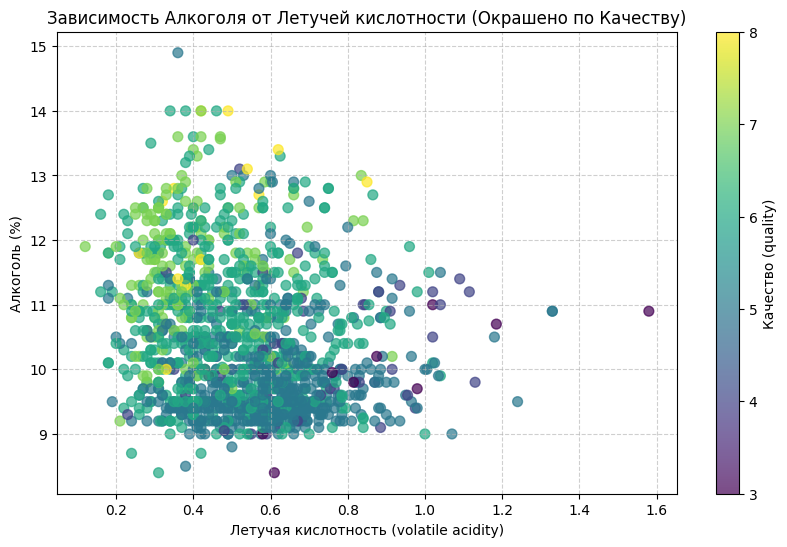

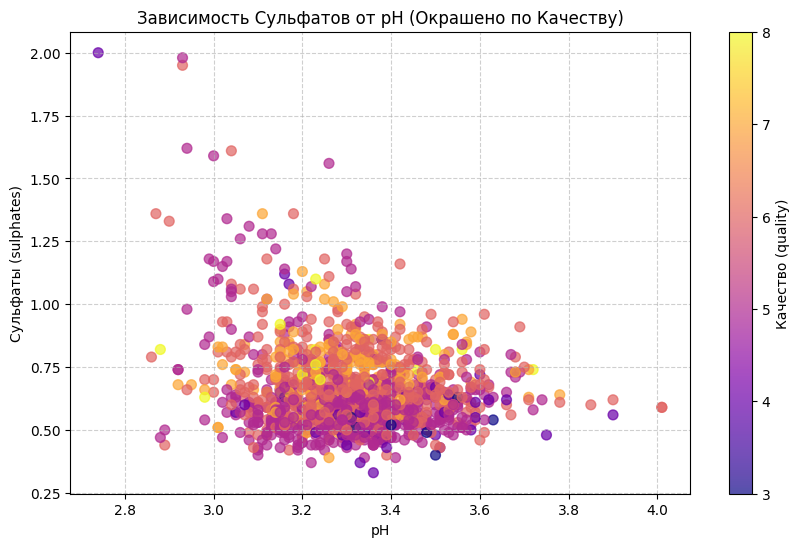

In [18]:
# --- 1. Алкоголь vs. Летучая кислотность ---
plt.figure(figsize=(10, 6))
scatter1 = plt.scatter(df['volatile acidity'], df['alcohol'], 
                       c=df['quality'], cmap='viridis',  # Окрашиваем по качеству
                       alpha=0.7, s=50)
plt.title('Зависимость Алкоголя от Летучей кислотности (Окрашено по Качеству)')
plt.xlabel('Летучая кислотность (volatile acidity)')
plt.ylabel('Алкоголь (%)')
plt.colorbar(scatter1, label='Качество (quality)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 2. Сульфаты vs. pH ---
plt.figure(figsize=(10, 6))
scatter2 = plt.scatter(df['pH'], df['sulphates'], 
                       c=df['quality'], cmap='plasma',
                       alpha=0.7, s=50)
plt.title('Зависимость Сульфатов от pH (Окрашено по Качеству)')
plt.xlabel('pH')
plt.ylabel('Сульфаты (sulphates)')
plt.colorbar(scatter2, label='Качество (quality)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Анализ графиков:

* Алкоголь vs. Летучая кислотность: На первом графике видна четкая тенденция. Точки высокого качества явно группируются в области низкой летучей кислотности и высокого содержания алкоголя. Точки низкого качества разбросаны, но чаще встречаются при более высокой летучей кислотности. Это уже похоже на 2-3 перекрывающихся кластера.

* Сульфаты vs. pH: Здесь явных "островков" нет. Группы сильно перекрываются. Однако можно заметить, что вина высокого качества чаще имеют более высокое содержание сульфатов.

Наиболее перспективным для кластеризации выглядит первый график.

<h3>4. Применить метод KMeans к вашему датасету.</h3>

К моему датусету применить его нельзя, поэтому возьму один из предложенных.

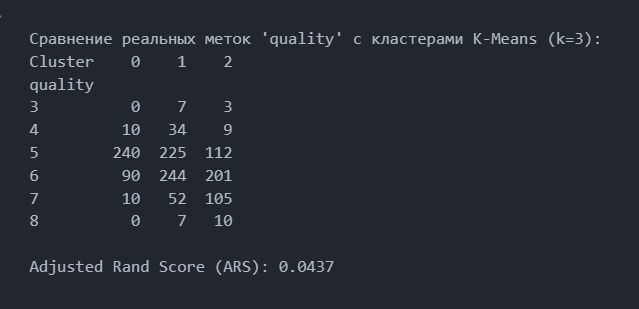

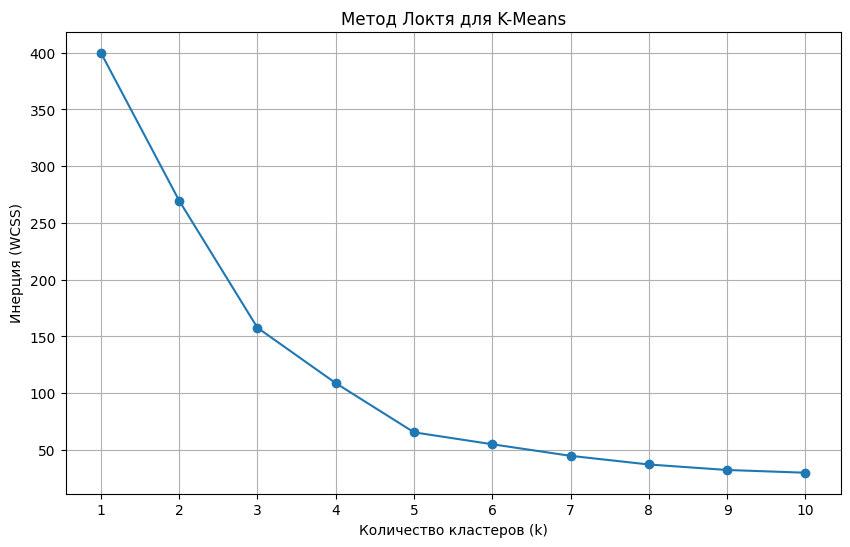

In [19]:
df = pd.read_csv('Mall_Customers.csv')

# Выбор признаков для кластеризации
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Поиск оптимального K (Метод Локтя) ---
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_elbow.fit(X_scaled)
    inertia.append(kmeans_elbow.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Метод Локтя для K-Means')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

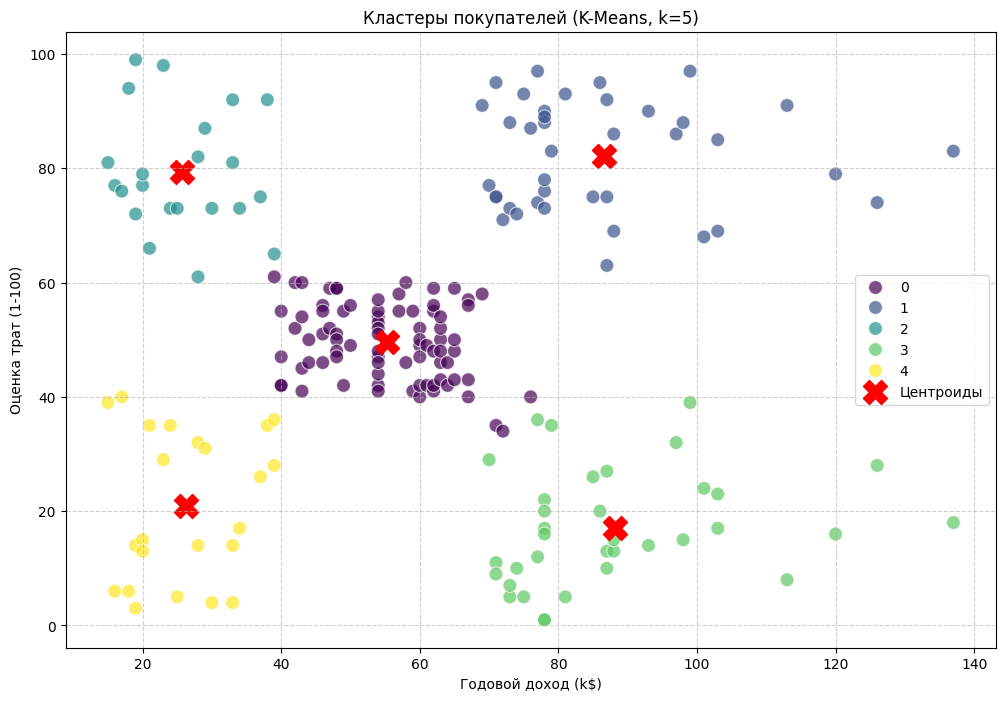

In [20]:
# --- Применение K-Means с k=5 ---

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

df['Cluster'] = y_kmeans

# --- Визуализация кластеров ---
plt.figure(figsize=(12, 8))
import seaborn as sns

sns.scatterplot(
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    hue='Cluster',
    data=df,
    palette='viridis',
    s=100,
    alpha=0.7,
    legend='full'
)

centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(
    centers[:, 0], centers[:, 1], 
    s=300,
    c='red',
    marker='X',
    label='Центроиды'
)

plt.title('Кластеры покупателей (K-Means, k=5)')
plt.xlabel('Годовой доход (k$)')
plt.ylabel('Оценка трат (1-100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<h3>5. Выводы</h3>

Визуализация кластеров наглядно демонстрирует, что алгоритм K-Means успешно разделил клиентов на 5 четких и логически объяснимых сегментов:

1) Кластер 0 (Фиолетовый): "Бережливые с высоким доходом"

* Характеристика: Высокий доход, но низкая оценка трат.

* Интерпретация: Это богатые клиенты, которые по какой-то причине мало тратят в этом ТЦ. Это "потенциальные" клиенты, на которых стоит направить целевой маркетинг, чтобы понять их потребности и увеличить их траты.

2) Кластер 1 (Бирюзовый): "Стандарт"

* Характеристика: Средний доход и средняя оценка трат.

* Интерпретация: Это самая большая и "средняя" группа покупателей. Они составляют ядро клиентской базы.

3) Кластер 2 (Зеленый): "Бережливые с низким доходом"

* Характеристика: Низкий доход и низкая оценка трат.

* Интерпретация: Эти клиенты тратят мало, вероятно, из-за ограниченного дохода. На них можно нацеливать акции и скидки.

4) Кластер 3 (Красный): "Транжиры с низким доходом"

* Характеристика: Низкий доход, но высокая оценка трат.

* Интерпретация: Интересная группа. Вероятно, это молодые люди или студенты, которые тратят много (возможно, на импульсивные покупки), несмотря на небольшой доход.

5) Кластер 4 (Желтый): "VIP / Целевые"

* Характеристика: Высокий доход и высокая оценка трат.

* Интерпретация: Это идеальные клиенты. Они и могут, и хотят тратить деньги. На эту группу должны быть нацелены программы лояльности, премиальные предложения и VIP-сервис.

K-Means доказал свою эффективность для задачи сегментации рынка. Не имея никаких предварительных данных о "типах" клиентов, алгоритм самостоятельно нашел 5 коммерчески значимых групп, для каждой из которых можно разработать отдельную маркетинговую стратегию.